# Crop Disease Classification with CNN (PlantVillage via TFDS)

This Colab notebook loads the PlantVillage dataset, trains a CNN model, and saves it for deployment.

## Step 1: Install Required Libraries

In [1]:
!pip install tensorflow tensorflow-datasets matplotlib

## Step 2: Import Libraries

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt


## Step 3: Load the PlantVillage Dataset from TFDS

In [3]:
(ds_train, ds_val), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

class_names = ds_info.features['label'].names
num_classes = ds_info.features['label'].num_classes

print(f"Total Classes: {num_classes}")
print("Sample classes:", class_names[:5])


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.DZ2PMD_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.
Total Classes: 38
Sample classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy']


## Step 4: Preprocess & Visualize

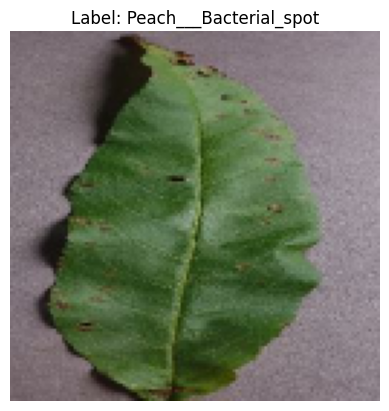

In [4]:
def format_example(image, label):
    image = tf.image.resize(image, (128, 128)) / 255.0
    return image, label

ds_train = ds_train.map(format_example).batch(32).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(format_example).batch(32).prefetch(tf.data.AUTOTUNE)

# Show sample
for images, labels in ds_train.take(1):
    plt.imshow(images[0])
    plt.title(f"Label: {class_names[labels[0].numpy()]}")
    plt.axis('off')
    plt.show()


## Step 5: Build CNN Model

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,309,542 (12.62 MB)

 Trainable params: 3,309,542 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

## 🏋️‍♀️ Step 6: Train the Model

In [ ]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=10
)


Epoch 1/10
 257/1358 ━━━━━━━━━━━━━━━━━━━━ 16:14 885ms/step - accuracy: 0.7245 - loss: 0.9056

## Step 7: Evaluate

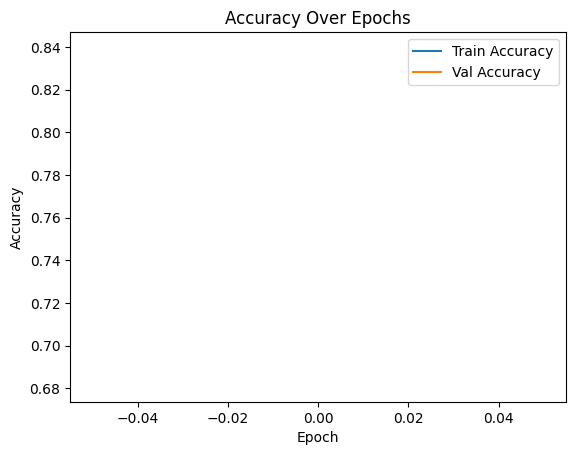

In [8]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Step 8: Save the Model

In [9]:
model.save("crop_model.h5")